#  Melt Rate Spatial Distibution VIDEOS

In [1]:
#Load required packages
%matplotlib inline
from matplotlib import pyplot as plt, animation
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
# this is to make sure there is no size limit
import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 2**128

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'


# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [3]:
sPerYr = 365.*24.*60.*60.


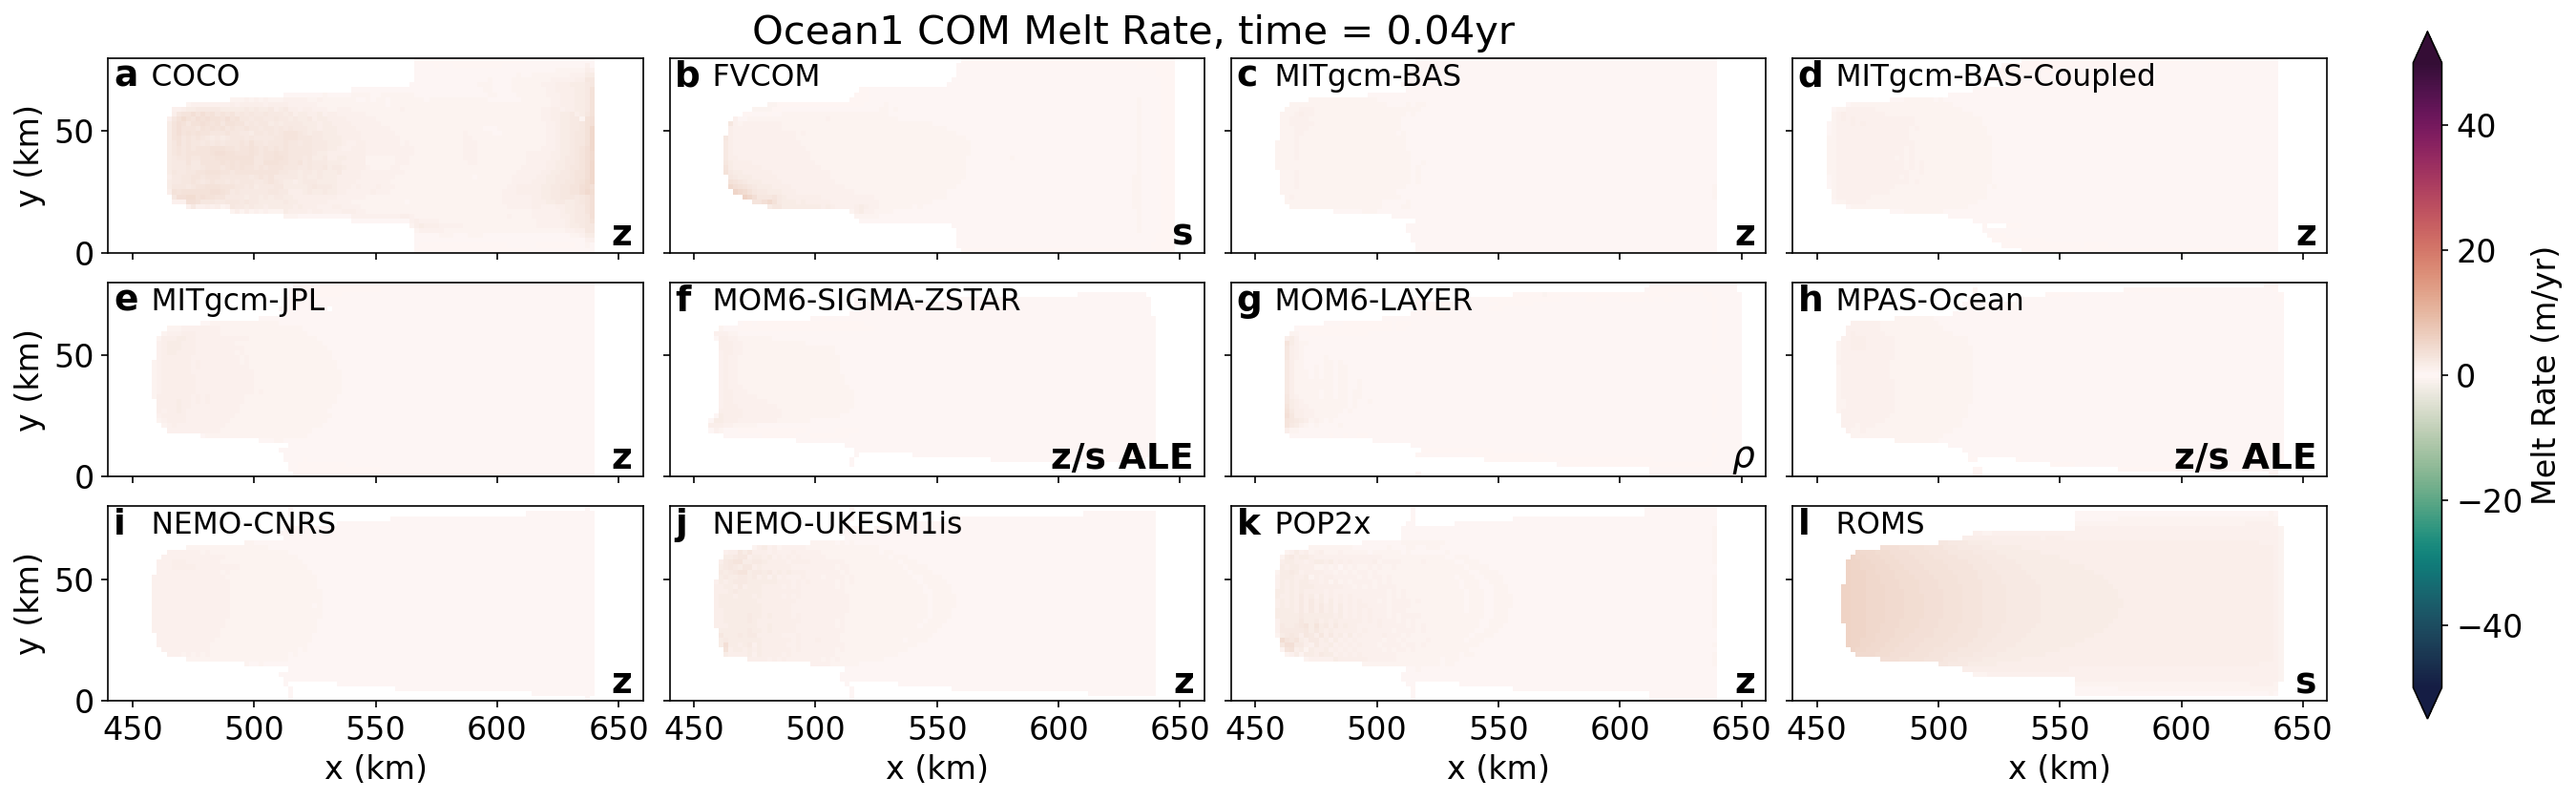

In [4]:
expt = Ocean1_COM
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
nrows = int(np.ceil(length/3))
fig = plt.figure(figsize=(20, 6),facecolor='w',dpi = 150)
time = 12

vmin = -50.
vmax = 50.

xlim = [440., 660.]

#Type of vertical coordinate
vert_coord_type = ['z','s','z','z','z','z/s ALE',r'$\rho$','z/s ALE','z','z','z','s']

axes = []
time = 0
for i in np.arange(length):
    ax = plt.subplot(3,nrows,i+1)
    axes = np.append(axes,ax)
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time'])
    nTime = ds.sizes['nTime']
    mr = ds.meltRate.isel(nTime=time)
    # mr < 1e36 is to get rid of fill values.
    mr = sPerYr * mr.where(mr < 1e36)
    mesh = plt.pcolormesh(
        1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
        cmap=cm.cm.curl, vmin=vmin, vmax=vmax, shading='nearest')
    plt.xlim(xlim)
    mesh.axes.set_aspect('equal')
    
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('y (km)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.tick_params(labelsize=16)
    t = plt.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
             fontweight='bold', va='bottom',color = 'k', ha = 'right')

cax = plt.axes([0.93, 0.1, 0.01, 0.8])
cbar = plt.colorbar(mesh, cax=cax, extend='both')
cbar.ax.set_ylabel('Melt Rate (m/yr)', fontsize=16)

plt.tick_params(labelsize=16)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

fig.suptitle('Ocean1 COM Melt Rate, time = '+'{0:.2f}'.format((time+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

def animate(frame):
    for i in np.arange(length):
        axes[i].clear()
        ax = axes[i]
        ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
        # make x and y coordinates
        ds = ds.set_coords(['x', 'y', 'time'])
        nTime = ds.sizes['nTime']
        mr = ds.meltRate.isel(nTime=frame)
        # mr < 1e36 is to get rid of fill values.
        mr = sPerYr * mr.where(mr < 1e36)
        mesh = ax.pcolormesh(
            1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
            cmap=cm.cm.curl, vmin=vmin, vmax=vmax, shading='nearest')
        ax.set_xlim(xlim)
        mesh.axes.set_aspect('equal')
        
        ax.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
        ax.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
        if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
            ax.set_yticklabels([])
        if (i<8):
            ax.set_xticklabels([])
        if (i==0) or (i==4) or (i==8):
            ax.set_ylabel('y (km)', fontsize = 16)
        else:
            ax.set_ylabel('')
        if i>=8:
            ax.set_xlabel('x (km)', fontsize = 16)
        else:
            ax.set_xlabel('')
        t = ax.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
                 fontweight='bold', va='bottom',color = 'k', ha = 'right')
    fig.suptitle('Ocean1 COM Melt Rate, time = '+'{0:.2f}'.format((frame+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=240,       # Could also be iterable or list
    interval=50     # ms between frames
)
#save!
ani.save('/g/data/x77/cy8964/isomip-plus/videos/Ocean1COMMeltRate.mp4',dpi = 300)

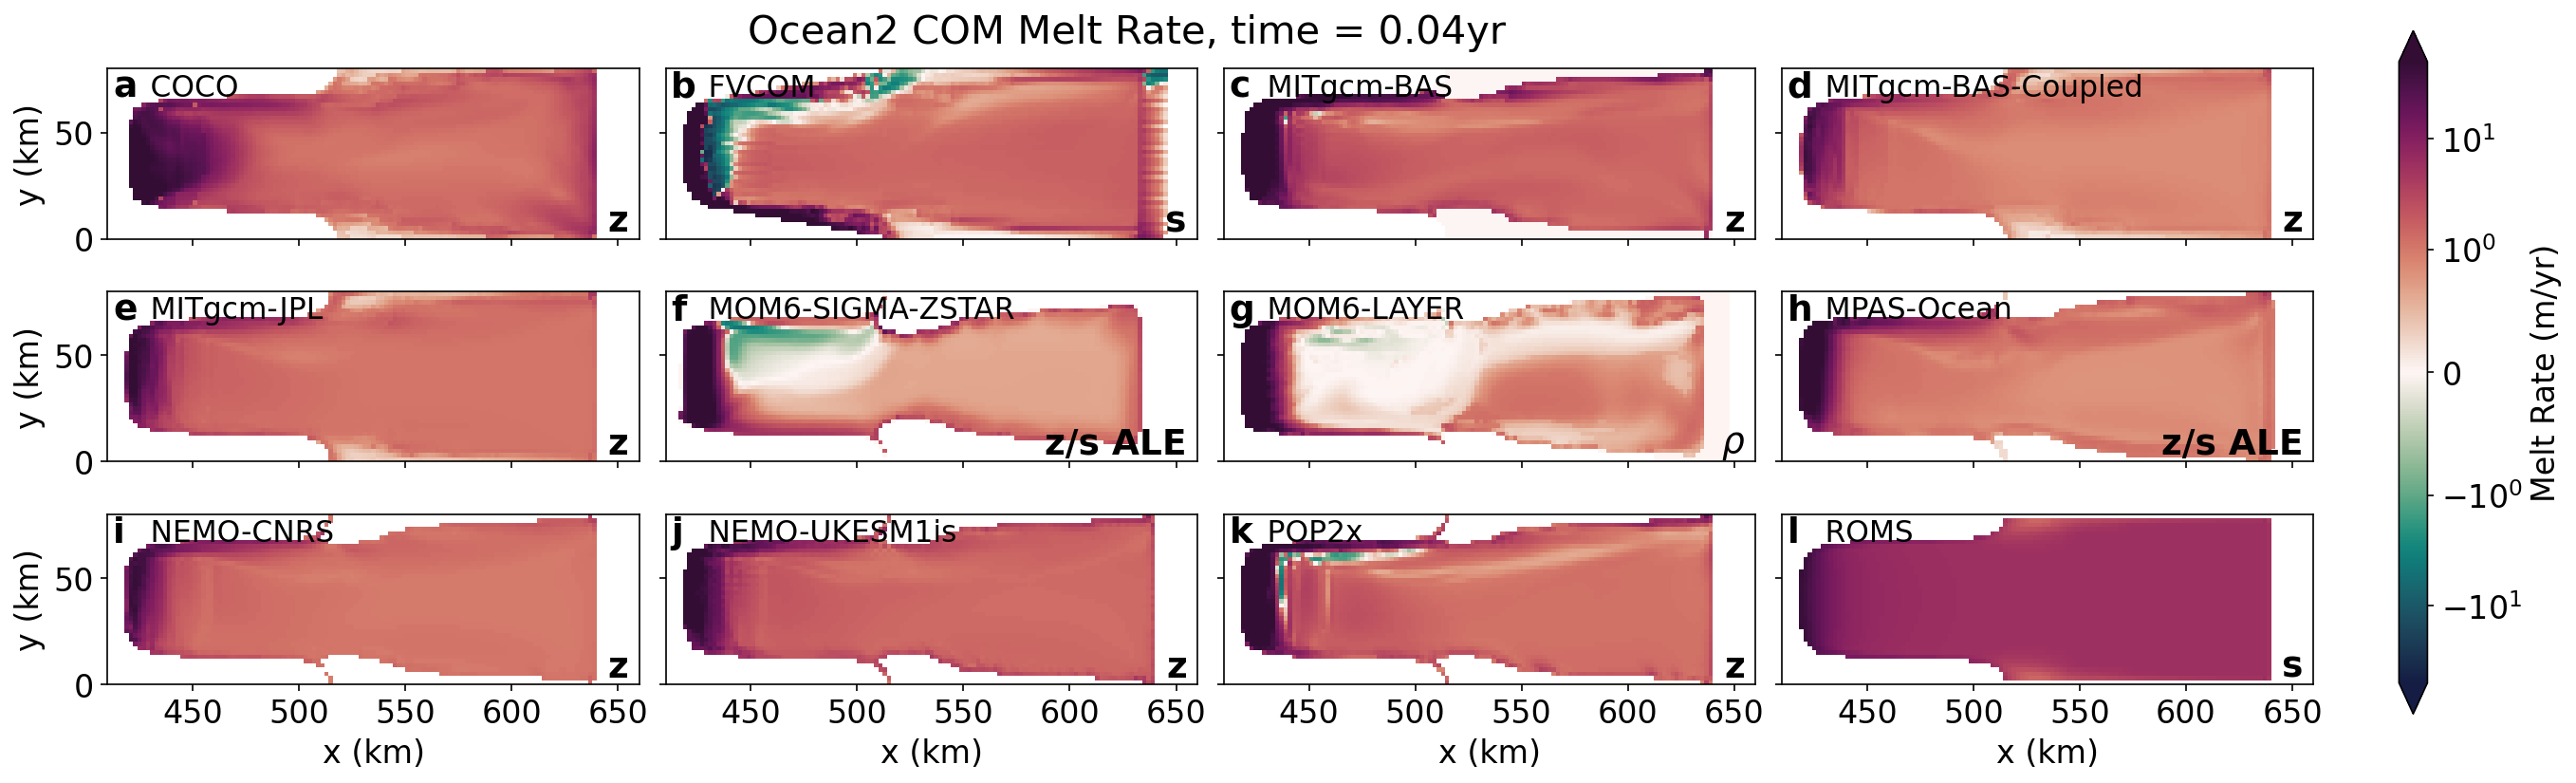

In [24]:
expt = Ocean2_COM
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
nrows = int(np.ceil(length/3))
fig = plt.figure(figsize=(20, 6),facecolor='w',dpi = 150)
time = 12

vmin = -50.
vmax = 50.

xlim = [410., 660.]

#Type of vertical coordinate
vert_coord_type = ['z','s','z','z','z','z/s ALE',r'$\rho$','z/s ALE','z','z','z','s']

axes = []
time = 0
for i in np.arange(length):
    ax = plt.subplot(3,nrows,i+1)
    axes = np.append(axes,ax)
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time'])
    nTime = ds.sizes['nTime']
    mr = ds.meltRate.isel(nTime=time)
    # mr < 1e36 is to get rid of fill values.
    mr = sPerYr * mr.where(mr < 1e36)
    mesh = ax.pcolormesh(
        1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
        cmap=cm.cm.curl, shading='nearest',norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-50, vmax=50, base=10))
    ax.set_xlim(xlim)
    mesh.axes.set_aspect('equal')
    
    ax.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    ax.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('y (km)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.tick_params(labelsize=16)
    t = plt.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
             fontweight='bold', va='bottom',color = 'k', ha = 'right')

cax = plt.axes([0.93, 0.1, 0.01, 0.8])
cbar = plt.colorbar(mesh, cax=cax, extend='both')
cbar.ax.set_ylabel('Melt Rate (m/yr)', fontsize=16)
plt.tick_params(labelsize=16)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)
#cbar.ax.set_yscale('symlog')

fig.suptitle('Ocean2 COM Melt Rate, time = '+'{0:.2f}'.format((time+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

def animate(frame):
    for i in np.arange(length):
        axes[i].clear()
        ax = axes[i]
        ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
        # make x and y coordinates
        ds = ds.set_coords(['x', 'y', 'time'])
        nTime = ds.sizes['nTime']
        mr = ds.meltRate.isel(nTime=frame)
        # mr < 1e36 is to get rid of fill values.
        mr = sPerYr * mr.where(mr < 1e36)
        mesh = ax.pcolormesh(
            1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
            cmap=cm.cm.curl,  shading='nearest', norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-50, vmax=50, base=10))
        ax.set_xlim(xlim)
        mesh.axes.set_aspect('equal')
        
        ax.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
        ax.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
        if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
            ax.set_yticklabels([])
        if (i<8):
            ax.set_xticklabels([])
        if (i==0) or (i==4) or (i==8):
            ax.set_ylabel('y (km)', fontsize = 16)
        else:
            ax.set_ylabel('')
        if i>=8:
            ax.set_xlabel('x (km)', fontsize = 16)
        else:
            ax.set_xlabel('')
        t = ax.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
                 fontweight='bold', va='bottom',color = 'k', ha = 'right')
    fig.suptitle('Ocean2 COM Melt Rate, time = '+'{0:.2f}'.format((frame+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=240,       # Could also be iterable or list
    interval=50     # ms between frames
)
#save!
ani.save('/g/data/x77/cy8964/isomip-plus/videos/Ocean2COMMeltRate.mp4',dpi = 300)

# TYP

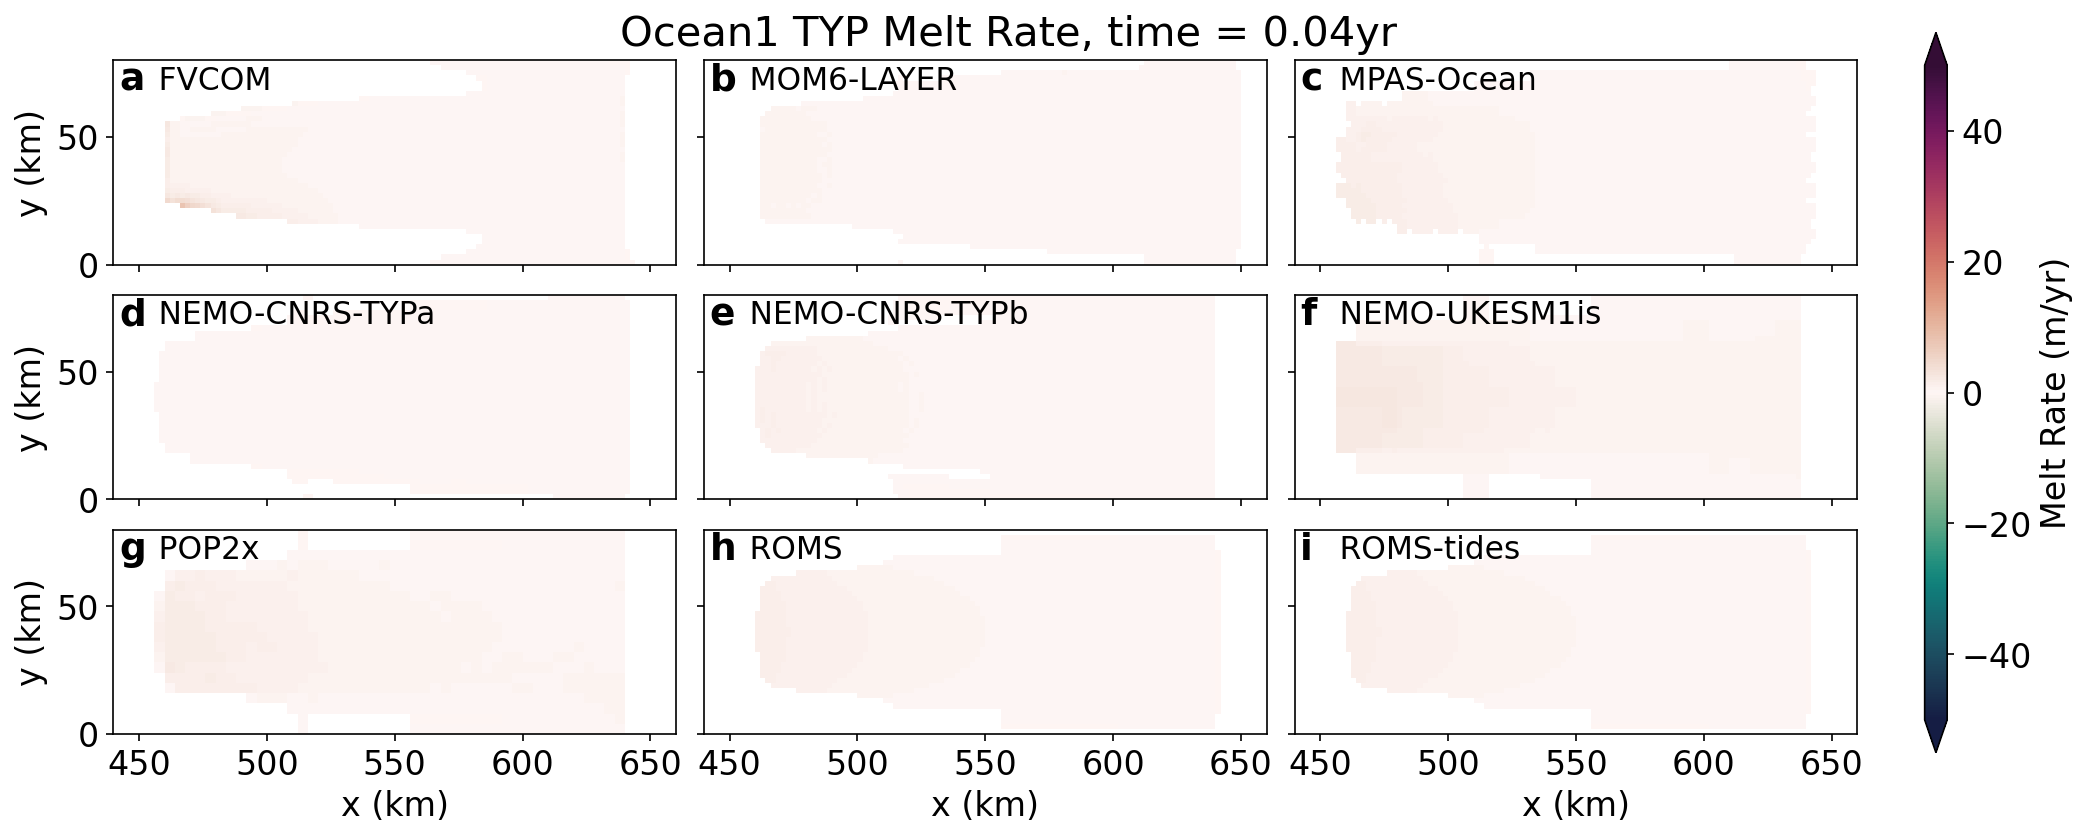

In [26]:
expt = Ocean1_TYP
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
nrows = int(np.ceil(length/3))
fig = plt.figure(figsize=(15, 6),facecolor='w',dpi = 150)
time = 12

vmin = -50.
vmax = 50.

xlim = [440., 660.]

#Type of vertical coordinate
#vert_coord_type = ['z','s','z','z','z','z/s ALE',r'$\rho$','z/s ALE','z','z','z','s']

axes = []
time = 0
for i in np.arange(length):
    ax = plt.subplot(3,nrows,i+1)
    axes = np.append(axes,ax)
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time'])
    nTime = ds.sizes['nTime']
    mr = ds.meltRate.isel(nTime=time)
    # mr < 1e36 is to get rid of fill values.
    mr = sPerYr * mr.where(mr < 1e36)
    mesh = plt.pcolormesh(
        1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
        cmap=cm.cm.curl, vmin=vmin, vmax=vmax, shading='nearest')
    plt.xlim(xlim)
    mesh.axes.set_aspect('equal')
    
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==4) or (i==5) or (i==7) or (i==8) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<6):
        ax.set_xticklabels([])
    if (i==0) or (i==3) or (i==6):
        plt.ylabel('y (km)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=6:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.tick_params(labelsize=16)
    # t = plt.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
    #          fontweight='bold', va='bottom',color = 'k', ha = 'right')

cax = plt.axes([0.93, 0.1, 0.01, 0.8])
cbar = plt.colorbar(mesh, cax=cax, extend='both')
cbar.ax.set_ylabel('Melt Rate (m/yr)', fontsize=16)

plt.tick_params(labelsize=16)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

fig.suptitle('Ocean1 TYP Melt Rate, time = '+'{0:.2f}'.format((time+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

def animate(frame):
    for i in np.arange(length):
        axes[i].clear()
        ax = axes[i]
        ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
        # make x and y coordinates
        ds = ds.set_coords(['x', 'y', 'time'])
        nTime = ds.sizes['nTime']
        mr = ds.meltRate.isel(nTime=frame)
        # mr < 1e36 is to get rid of fill values.
        mr = sPerYr * mr.where(mr < 1e36)
        mesh = ax.pcolormesh(
            1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
            cmap=cm.cm.curl, vmin=vmin, vmax=vmax, shading='nearest')
        ax.set_xlim(xlim)
        mesh.axes.set_aspect('equal')
        
        ax.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
        ax.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
        if (i==1) or (i==2) or (i==4) or (i==5) or (i==7) or (i==8) or (i==9) or (i==10) or (i==11):
            ax.set_yticklabels([])
        if (i<6):
            ax.set_xticklabels([])
        if (i==0) or (i==3) or (i==6):
            ax.set_ylabel('y (km)', fontsize = 16)
        else:
            ax.set_ylabel('')
        if i>=6:
            ax.set_xlabel('x (km)', fontsize = 16)
        else:
            ax.set_xlabel('')
        # t = ax.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
        #          fontweight='bold', va='bottom',color = 'k', ha = 'right')
    fig.suptitle('Ocean1 TYP Melt Rate, time = '+'{0:.2f}'.format((frame+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=240,       # Could also be iterable or list
    interval=50     # ms between frames
)
#save!
ani.save('/g/data/x77/cy8964/isomip-plus/videos/Ocean1TYPMeltRate.mp4',dpi = 300)

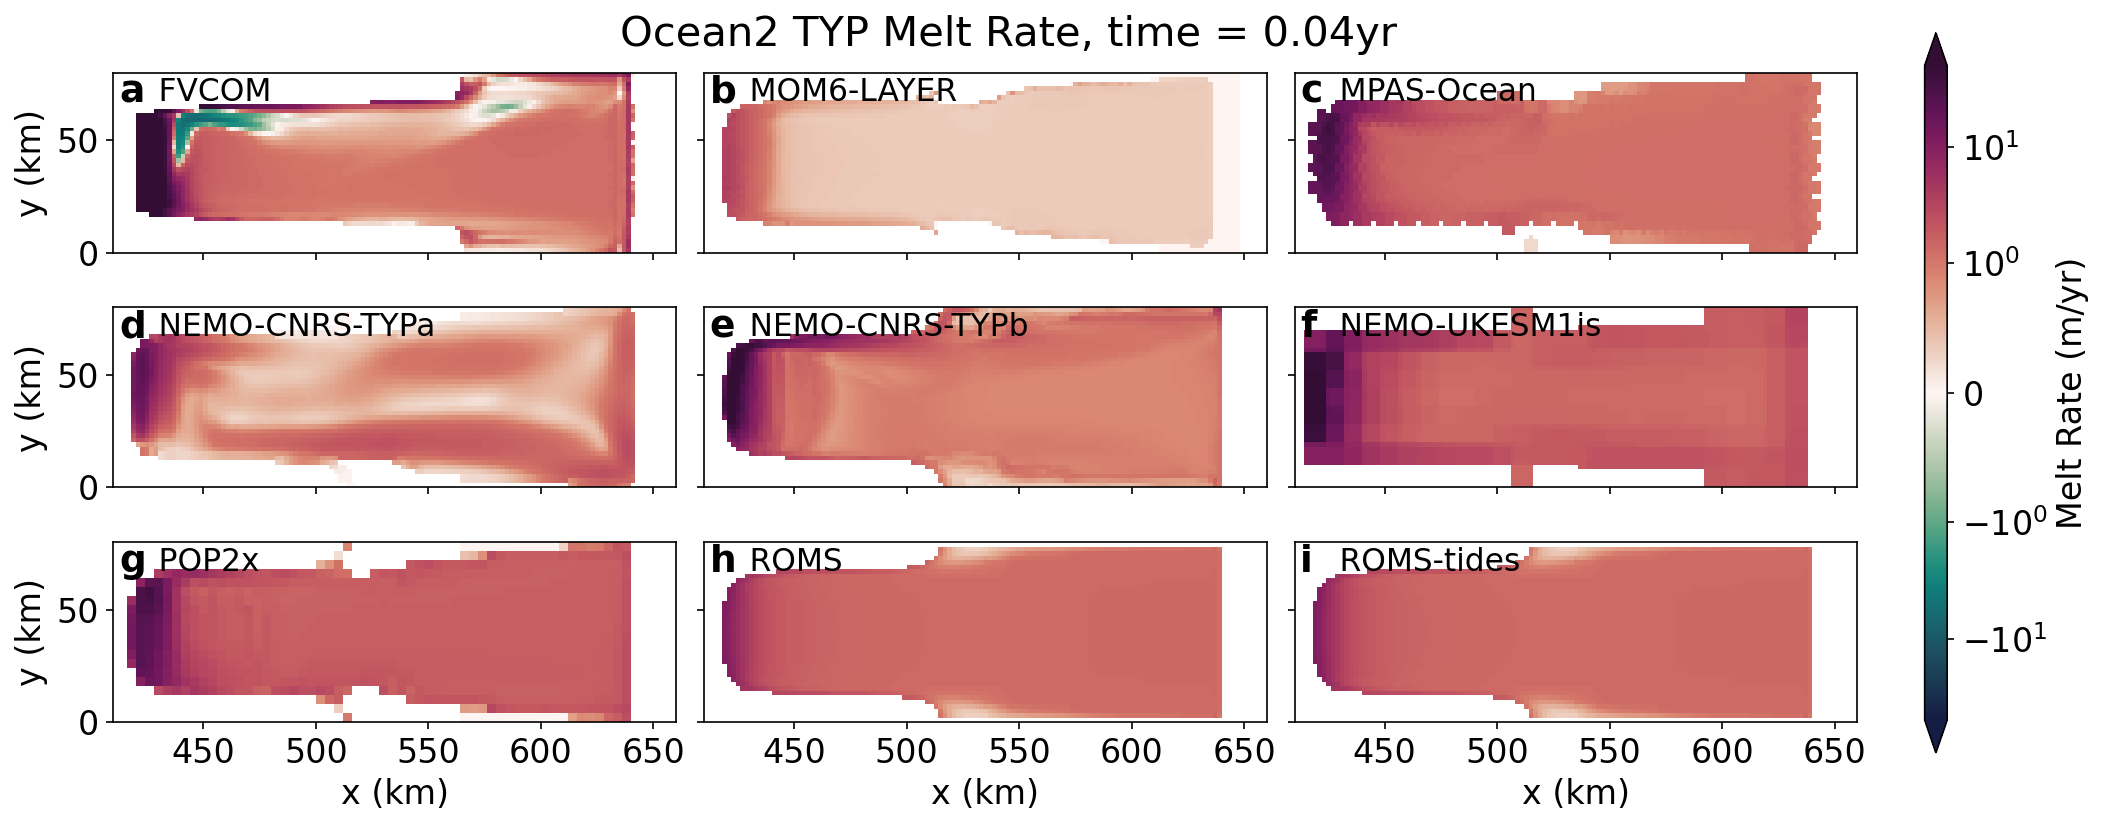

In [25]:
expt = Ocean2_TYP
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
nrows = int(np.ceil(length/3))
fig = plt.figure(figsize=(15, 6),facecolor='w',dpi = 150)
time = 12

vmin = -50.
vmax = 50.

xlim = [410., 660.]

#Type of vertical coordinate
vert_coord_type = ['z','s','z','z','z','z/s ALE',r'$\rho$','z/s ALE','z','z','z','s']

axes = []
time = 0
for i in np.arange(length):
    ax = plt.subplot(3,nrows,i+1)
    axes = np.append(axes,ax)
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time'])
    nTime = ds.sizes['nTime']
    mr = ds.meltRate.isel(nTime=time)
    # mr < 1e36 is to get rid of fill values.
    mr = sPerYr * mr.where(mr < 1e36)
    mesh = ax.pcolormesh(
        1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
        cmap=cm.cm.curl, shading='nearest',norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-50, vmax=50, base=10))
    ax.set_xlim(xlim)
    mesh.axes.set_aspect('equal')
    
    ax.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    ax.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==4) or (i==5) or (i==7) or (i==8) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<6):
        ax.set_xticklabels([])
    if (i==0) or (i==3) or (i==6):
        plt.ylabel('y (km)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=6:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.tick_params(labelsize=16)
    # t = plt.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
    #          fontweight='bold', va='bottom',color = 'k', ha = 'right')

cax = plt.axes([0.93, 0.1, 0.01, 0.8])
cbar = plt.colorbar(mesh, cax=cax, extend='both')
cbar.ax.set_ylabel('Melt Rate (m/yr)', fontsize=16)
plt.tick_params(labelsize=16)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)
#cbar.ax.set_yscale('symlog')

fig.suptitle('Ocean2 TYP Melt Rate, time = '+'{0:.2f}'.format((time+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

def animate(frame):
    for i in np.arange(length):
        axes[i].clear()
        ax = axes[i]
        ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
        # make x and y coordinates
        ds = ds.set_coords(['x', 'y', 'time'])
        nTime = ds.sizes['nTime']
        mr = ds.meltRate.isel(nTime=frame)
        # mr < 1e36 is to get rid of fill values.
        mr = sPerYr * mr.where(mr < 1e36)
        mesh = ax.pcolormesh(
            1e-3 * ds.x.values, 1e-3 * ds.y.values, mr.values, 
            cmap=cm.cm.curl,  shading='nearest', norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-50, vmax=50, base=10))
        ax.set_xlim(xlim)
        mesh.axes.set_aspect('equal')
        
        ax.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
        ax.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
        if (i==1) or (i==2) or (i==4) or (i==5) or (i==7) or (i==8) or (i==10) or (i==11):
            ax.set_yticklabels([])
        if (i<6):
            ax.set_xticklabels([])
        if (i==0) or (i==3) or (i==6):
            ax.set_ylabel('y (km)', fontsize = 16)
        else:
            ax.set_ylabel('')
        if i>=6:
            ax.set_xlabel('x (km)', fontsize = 16)
        else:
            ax.set_xlabel('')
        # t = ax.text(0.98,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
        #          fontweight='bold', va='bottom',color = 'k', ha = 'right')
    fig.suptitle('Ocean2 TYP Melt Rate, time = '+'{0:.2f}'.format((frame+0.5)/12)+'yr', y = 0.92, x= 0.35, ha = 'left', fontsize = 20);

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=240,       # Could also be iterable or list
    interval=50     # ms between frames
)
#save!
ani.save('/g/data/x77/cy8964/isomip-plus/videos/Ocean2TYPMeltRate.mp4',dpi = 300)